#  **Introdução**
## **Análise de dados do tipo predição, usando o algoritmo RandomForestClassifier para prever se um passageiro do Titanic sobreviveu ou não**

# Importando os dados

In [72]:
#Importando os dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')


# Visualização de dados

In [73]:
data_train.head(5) 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


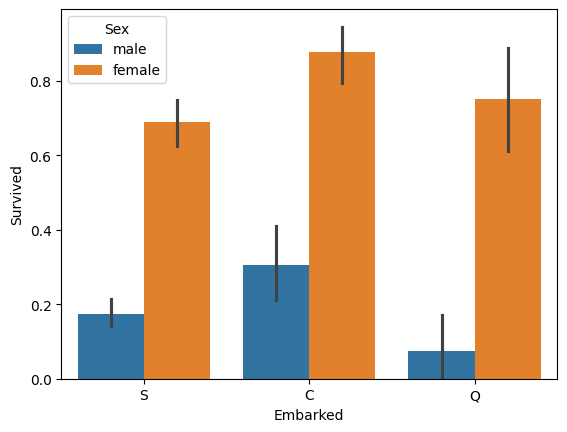

In [74]:
sns.barplot(x ="Embarked", y = "Survived", hue="Sex", data=data_train)
plt.show()


## Vamos simplificar as idades em Desconhecido, Bebê, Criança, Adolecente, Estudante, Joven adulto, Adulto, Idoso

In [75]:
def simplify_ages(df): #Cria a função para idades
    df.Age = df.Age.fillna(-0.5) #Preenche os valores ausentes na coluna Age(idade)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120) #Limites das idades de cada grupo de pessoas
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Studant', 'Young Adult','Adult', 'Senior'] #grupo de pessoas
    categories = pd.cut(df.Age, bins, labels=group_names) # Aqui eu categorizo as idades definidos pelos intervalos de bins e associo a group_names.
    df.Age = categories # Aqui eu substitui a coluna idade pelos 
    return df   # Retorna o DataFrame modificado

## Vamos reduzir as cabines vazias

In [76]:
def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')# Preenche os valores ausentes na coluna 'Cabin' com 'N'
    df.Cabin = df.Cabin.apply(lambda x: x[0]) # Aplica uma função lambda para extrair o primeiro caractere de cada valor na coluna 'Cabin'
    return df  # Retorna o DataFrame modificado

## Categoriza as tarifas dos passageiros em intervalos específicos

In [77]:
def simplify_fares(df):

    df.Fare = df.Fare.fillna(-0.5) # Preenche os valores ausentes na coluna 'Fare' com -0.5
    # Define os intervalos e rótulos para categorizar as tarifas
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)# Categoriza as tarifas com base nos intervalos e rótulos definidos
    df.Fare = categories# Substitui os valores da coluna 'Fare' pelos rótulos das categorias
    return df # Retorna o DataFrame modificado



## Separando o primeiro e segundo nome

In [78]:
def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0]) # Cria uma nova coluna 'Lname' contendo apenas o sobrenome de cada passageiro
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])  #Cria uma nova coluna 'NamePrefix' contendo o prefixo do nome de cada passageiro (como Mr., Miss, etc.)
    
    return df  # Retorna o DataFrame modificado

# Remove as colunas Ticket, Name, Embarked, já que não será mais utilizada.

In [79]:
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)# Remove as colunas 'Ticket', 'Name' e 'Embarked' do DataFrame


# Chamando as funções

In [80]:
def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

# Aqui eu aplico todas as mudanças no dataframe

In [81]:
data_train = transform_features(data_train)
data_test = transform_features(data_test)

### Vamos importar o modulo preprocessing da biblioteca sklearn

In [82]:
from sklearn import preprocessing #importanto o modulo preprocessing 

# Conjunto de dados

In [83]:
def encode_features(df_train, df_test): #conjuntos de dados de treinamento e teste, respectivamente
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(data_train, data_test)

# Vamos treinar os dados

In [84]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

# Ajustando o algoritimo

In [85]:
#Importação de bibliotecas:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV


#Classificador
clf = RandomForestClassifier()

# parâmetros para a busca em grade
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }
#pontuação usado para comparar combinações de parâmetros:
acc_scorer = make_scorer(accuracy_score)

# Execução da busca em grade
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Atribuição do melhor estimador ao classificador
clf = grid_obj.best_estimator_

# Treinamento do modelo final
clf.fit(X_train, y_train)

In [ ]:
# Fazendo previsões no conjunto de testes
predictions = clf.predict(X_test)

# Avaliando a acurácia das previsões
print(accuracy_score(y_test, predictions))

0.8156424581005587


In [ ]:
from sklearn.model_selection import KFold

def run_kfold(clf):
    # Defina o objeto KFold com 10 dobras
    kf = KFold(n_splits=10)
    outcomes = []  # Lista para armazenar as acurácias de cada dobra
    fold = 0  # Contador de dobras
    for train_index, test_index in kf.split(X_all):
        fold += 1
        # Divida os dados em conjuntos de treinamento e teste com base nos índices fornecidos pela dobra atual
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        # Treine o classificador com os dados de treinamento
        clf.fit(X_train, y_train)
        # Faça previsões nos dados de teste
        predictions = clf.predict(X_test)
        # Calcule a acurácia das previsões
        accuracy = accuracy_score(y_test, predictions)
        # Adicione a acurácia ao lista de resultados
        outcomes.append(accuracy)
        # Imprima a acurácia da dobra atual
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    # Calcule a média das acurácias de todas as dobras
    mean_outcome = np.mean(outcomes)
    # Imprima a média das acurácias
    print("Mean Accuracy: {0}".format(mean_outcome)) 

# Execute a validação cruzada com o classificador clf
run_kfold(clf)


In [ ]:
ids = data_test['PassengerId']  # Obter os IDs dos passageiros do conjunto de dados de teste
predictions = clf.predict(data_test.drop('PassengerId', axis=1))  # Fazer previsões de sobrevivência para o conjunto de dados de teste, excluindo a coluna 'PassengerId'
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })  # Criar um DataFrame com os IDs dos passageiros e as previsões de sobrevivência correspondentes
output.sum()  # Somar as previsões de sobrevivência (1 para sobrevivente, 0 para não sobrevivente)


PassengerId    460009
Survived          154
dtype: int64